In [1]:
# To run this in Google Colab, uncomment the following line
# !pip install "git+https://github.com/GPflow/GeometricKernels.git"

# If you want to use a version of the library from a different git branch,
# say, from the "devel" branch, uncomment the line below instead
# !pip install "git+https://github.com/GPflow/GeometricKernels@devel#egg=GeometricKernels"

# Matérn and Heat Kernels on the Hyperbolic Spaces

This notebook shows how define and evaluate kernels on the two-dimensional hyperbolic space $\mathbb{H}_2$.

Handling higher-dimensional hyperbolic spaces $\mathbb{H}_d$ for $d \geq 2$ is essentially the same.
We chose to showcase $\mathbb{H}_2$ here because (1) it is probably the most well known case (2) it is easy to visualize.

**Note:** the points on the hyperbolic space $\mathbb{H}_d$ are represented by $d+1$-dimensional vectors (`array`s of the suitable backend) satisfying $x_1^2 - x_2^2 - \ldots - x_{d+1}^2 = 1$ (i.e. lying on the hyperboloid).

We use the **numpy** backend here.

In [2]:
# Import a backend, we use numpy in this example.
import numpy as np
# Import the geometric_kernels backend.
import geometric_kernels

# Note: if you are using a backend other than numpy,
# you _must_ uncomment one of the following lines
# import geometric_kernels.tensorflow
# import geometric_kernels.torch
# import geometric_kernels.jax

# Import a space and an appropriate kernel.
from geometric_kernels.spaces import Hyperbolic
from geometric_kernels.kernels import MaternGeometricKernel

import matplotlib as mpl
import matplotlib.pyplot as plt

import geomstats.visualization as visualization

INFO: Using numpy backend


## Defining a Space

First we create a GeometricKernels `space` that corresponds to the 2-dimensional hyperbolic space $\mathbb{H}_2$.

In [3]:
hyperbolic_space = Hyperbolic(dim=2)

## Defining a Kernel

To initialize `MaternGeometricKernel` you need to provide a `Space` object, in our case this is the `hyperbolic_space` we have just created above.
Additionally, there is a mandatory keyword argument `key` which should be equal to a random generator that is **specific to the backend you are using**.
This is because `MaternGeometricKernel` on non-compact symmetric spaces is a random Monte Carlo approximation. Notably, this implies that kernel can be (slightly) different every time.

There is also an optional parameter `num` which determines the order of approximation of the kernel (*number of levels*).
There is a sensible default value for each of the spaces in the library, so change it only if you know what you are doing.

A brief account on theory behind the kernels on non-compact symmetric spaces (which hyperbolic spaces are instances of) can be found on this [documentation page](https://gpflow.github.io/GeometricKernels/theory/symmetric.html).

First, we define randomness

In [4]:
key = np.random.RandomState(seed=1234)

Now we are ready to create a generic Matérn kernel.

In [5]:
kernel = MaternGeometricKernel(hyperbolic_space, key=key)

To support JAX, our classes do not keep variables you might want to differentiate over in their state.
Instead, some methods take a `params` dictionary as input, returning its modified version.

The next line initializes the dictionary of kernel parameters `params` with some default values.

**Note:** our kernels do not contain the outputscale/variance parameter frequently used in Gaussian processes.
However, it is usually trivial to add it by multiplying the kernel by an (optimizable) constant.

In [6]:
params = kernel.init_params()
print('params:', params)

params: {'nu': array(inf), 'lengthscale': array(1.)}


To define two different kernels, Matern-3/2 and Matern-∞ (aka heat, RBF, squared exponential, diffusion), we need two different versions of `params`:

In [7]:
params["lengthscale"] = np.array([1.5])
params_32  = params.copy()
params_inf = params.copy()
del params
params_32["nu"]  = np.array([3/2])
params_inf["nu"] = np.array([np.inf])

Now two kernels are *defined* and we proceed to evaluating both on a set of random inputs.

## Evaluating Kernels on Random Inputs

We start by sampling `10` random points on the sphere $\mathbb{H}_2$.
Since hyperbolic spaces are noncompact, the sampling cannot be uniform.
Here we resort to the default sampling routine from the [geomstats](https://geomstats.github.io/index.html) package.

In [8]:
xs = hyperbolic_space.random_point(10)

print(xs)

[[ 1.16221053 -0.50807394  0.30429294]
 [ 1.56310588 -0.95764845  0.72540295]
 [ 1.18595332  0.38743548 -0.50633884]
 [ 1.15721885 -0.0969265  -0.57424796]
 [ 1.23345114 -0.56737899 -0.44663498]
 [ 1.32037632  0.86202372 -0.0175708 ]
 [ 1.29100374  0.38820634  0.718322  ]
 [ 1.43429384  0.68291657  0.76865063]
 [ 1.3193674  -0.75434206 -0.41436502]
 [ 1.24711126  0.27680611 -0.69185611]]


Now we evaluate the two kernel matrices.

In [9]:
kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_inf = kernel.K(params_inf, xs, xs)

Finally, we visualize these matrices using `imshow`.

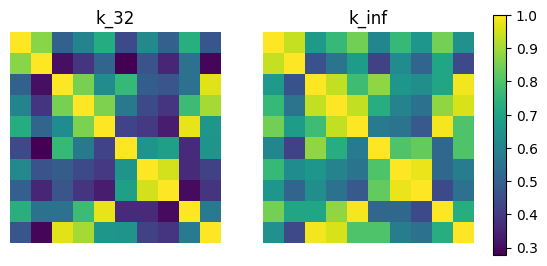

In [10]:
# find common range of values
minmin = np.min([np.min(kernel_mat_32), np.min(kernel_mat_inf)])
maxmax = np.max([np.max(kernel_mat_32), np.max(kernel_mat_inf)])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cmap = plt.get_cmap('viridis')

ax1.imshow(kernel_mat_32, vmin=minmin, vmax=maxmax, cmap=cmap)
ax1.set_title('k_32')
ax1.set_axis_off()

ax2.imshow(kernel_mat_inf, vmin=minmin, vmax=maxmax, cmap=cmap)
ax2.set_title('k_inf')
ax2.set_axis_off()

# add space for color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin, vmax=maxmax))
fig.colorbar(sm, cax=cbar_ax)

plt.show()

## Visualize Kernels

The hyperbolic spaces $\mathbb{H}_2$ is one of the few manifolds we can visualize.
Because of this, beyond kernel matrices, we will plot the functions $k_{\nu, \kappa}(*, \cdot)$.

In practice, we visualize $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points`.
The `base_point` is the center of the Poincaré disk.
The `other_points` is defined as a grid thereon.
Here we exploit the fact that `Hyperbolic` inherits from `geomstats` [Hyperbolic](https://geomstats.github.io/_modules/geomstats/geometry/hyperbolic.html#Hyperbolic).

We define `base_point` and `other_points` in the next cell.

In [11]:
base_point = hyperbolic_space.from_coordinates(np.r_[0, 0], "intrinsic").reshape(1, 3)

s = np.linspace(-5, 5, 100)
xx, yy = np.meshgrid(s, s)
other_points = np.c_[xx.ravel(), yy.ravel()]
other_points = hyperbolic_space.from_coordinates(other_points, "intrinsic")

The next cell evaluates $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points` for $\nu$ either $3/2$ or $\infty$.

In [12]:
kernel_vals_32  = kernel.K(params_32,  base_point, other_points)
kernel_vals_inf = kernel.K(params_inf, base_point, other_points)

Finally, we are ready to plot the results.

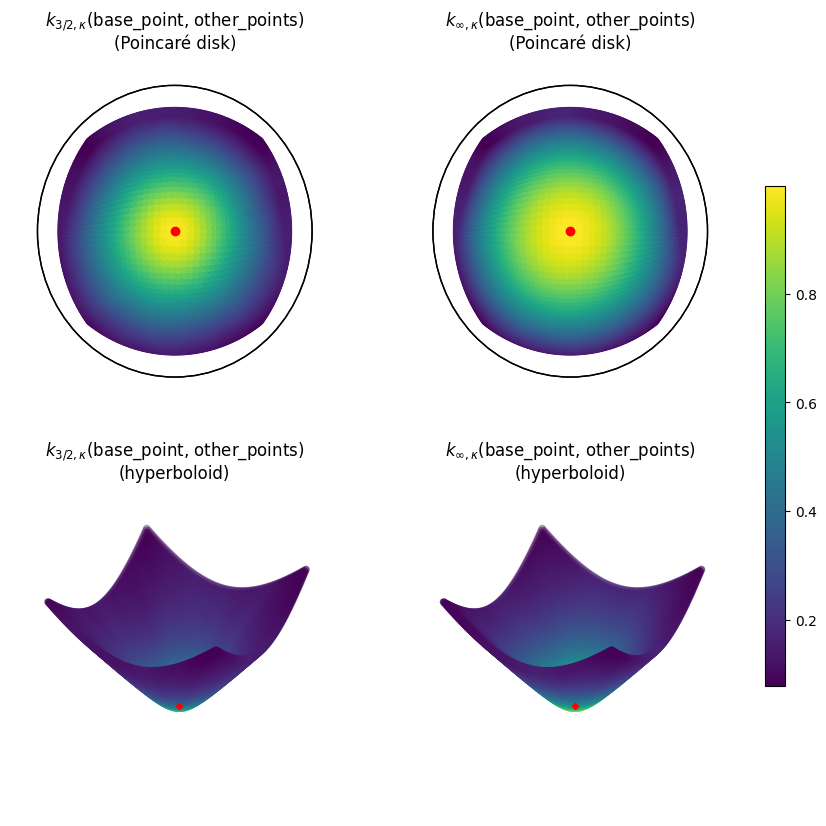

In [13]:
# fig, (ax1, ax2) = plt.subplots(figsize= (10, 10), nrows=2, ncols=2)
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3, projection='3d', computed_zorder=False)
ax4 = fig.add_subplot(2, 2, 4, projection='3d', computed_zorder=False)

cmap = plt.get_cmap('viridis')

visualization.plot(other_points, space="H2_poincare_disk", c=kernel_vals_32,  cmap=cmap, ax=ax1)
visualization.plot(other_points, space="H2_poincare_disk", c=kernel_vals_inf, cmap=cmap, ax=ax2)
ax3.scatter(other_points[:, 2], other_points[:, 1], other_points[:, 0],
                         c=kernel_vals_32[0], cmap=cmap)
ax4.scatter(other_points[:, 2], other_points[:, 1], other_points[:, 0],
                         c=kernel_vals_inf[0], cmap=cmap)


# Remove axis
ax1.set_axis_off()
ax2.set_axis_off()
ax3._axis3don = False
ax4._axis3don = False

# plot the base point
visualization.plot(base_point, space="H2_poincare_disk", c='red', ax=ax1)
visualization.plot(base_point, space="H2_poincare_disk", c='red', ax=ax2)
ax3.scatter(base_point[0, 2], base_point[0, 1], base_point[0, 0], s=10, c='r', marker='D')
ax4.scatter(base_point[0, 2], base_point[0, 1], base_point[0, 0], s=10, c='r', marker='D')

# find common range of values
minmin_vis = np.min([np.min(kernel_vals_32), np.min(kernel_vals_inf)])
maxmax_vis = np.max([np.max(kernel_vals_32), np.max(kernel_vals_inf)])

# add space for color bar
ax1.set_title(r'$k_{3/2, \kappa}($base_point, other_points$)$'   '\n(Poincaré disk)')
ax2.set_title('$k_{\infty, \kappa}($base_point, other_points$)$' '\n(Poincaré disk)')
ax3.set_title(r'$k_{3/2, \kappa}($base_point, other_points$)$'   '\n(hyperboloid)')
ax4.set_title('$k_{\infty, \kappa}($base_point, other_points$)$' '\n(hyperboloid)')

sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin_vis, vmax=maxmax_vis))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])
fig.colorbar(sm, cax=cbar_ax)

plt.show()

# Citation

If you are using hyperbolic spaces and GeometricKernels, please consider citing

```
@article{azangulov2023,
    title={Stationary Kernels and Gaussian Processes on Lie Groups and their Homogeneous Spaces II: non-compact symmetric spaces},
    author={Azangulov, Iskander and Smolensky, Andrei and Terenin, Alexander and Borovitskiy, Viacheslav},
    journal={arXiv preprint arXiv:2301.13088},
    year={2023}
}
```